# Efficientnet과 Yolov5를 사용한 얼굴표정인식
[참고한 커널](https://www.kaggle.com/code/saworz/detecting-human-emotions-yolov5-efnet-b0#2.-Train-YOLOv5-to-detect-faces)

In [59]:
!pip install split-folders


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import requests
from zipfile import ZipFile
from pathlib import Path

import os
import glob

import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms

import torchmetrics
import mlxtend

import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List
from timeit import default_timer as timer
from matplotlib import patches as mpatches

from tqdm.auto import tqdm

import gc

from numba import cuda

from GPUtil import showUtilization as gpu_usage

import splitfolders

from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
import yaml

from os import listdir                  
from os.path import isfile, join

c:\Users\JonghyunShin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## 1. Training Efficientnet B0 to detect face emotions
### 1.1 Get the data

In [2]:
def extract_data(zipfile_path: Path, destination_path: Path) -> None:
    if destination_path.is_dir():
        print(f"{destination_path} exists.")
    else:
        print(f"{destination_path} doesn't exist, creating one ...")
        destination_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(destination_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print('Extracting files..')
            zip.extractall(destination_path)
            print('Extracting Finished')
    else:
        print('Data already extracted')

data_path = Path('C:/Users/JonghyunShin/OneDrive - 고려대학교/KUCC/머신러닝 스터디(3-2)/Week3')
zipfile_path = data_path / 'archive.zip'
images_path = data_path / 'emotions_dataset'

extract_data(zipfile_path, images_path)

C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset exists.
Data already extracted


- 데이터 경로 탐색: 데이터가 폴더별로 분류되어 있으므로, 각 폴더 별로 몇 개의 데이터가 존재하는지 파악해보자

In [3]:
def walk_through_dir(dir_path: Path) -> None: 
    """prints Dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' folder")

walk_through_dir(images_path)

There are 2 directories and 0 images in 'C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset' folder
There are 7 directories and 0 images in 'C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset\test' folder
There are 0 directories and 958 images in 'C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset\test\angry' folder
There are 0 directories and 111 images in 'C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset\test\disgusted' folder
There are 0 directories and 1024 images in 'C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset\test\fearful' folder
There are 0 directories and 1774 images in 'C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset\test\happy' folder
There are 0 directories and 1233 images in 'C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset\test\neutral' folder
There are

Random image path: C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\emotions_dataset\train\disgusted\im428.png
Random image class: disgusted
Image height: 48
Image width: 48


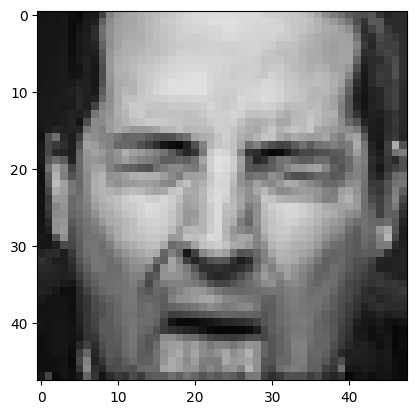

In [4]:
%matplotlib inline

def print_random_image(images_path: list, seed = None) -> None:
    if seed:
        random.seed(seed)

    random_image_path = random.choice(images_path)
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    print(f"Random image path: {random_image_path}")
    print(f"Random image class: {image_class}")
    print(f"Image height: {image.height}")
    print(f"Image width: {image.width}")
    plt.imshow(image.convert('P')) # 이미지를 그레이스케일로 변경

image_path_list = list(images_path.glob("*/*/*")) # images_path 하위의 모든 디렉토리를 반환
print_random_image(image_path_list)

### 1.2 Define transforms for train and validation data

In [5]:
train_transform = transforms.Compose(
    [transforms.Resize(size = (224, 224)),
     transforms.ToTensor()]
)

val_transform = transforms.Compose(
    [transforms.Resize(size = (224, 224)),
     transforms.ToTensor()]
)

- Visualize transformations
- transform된 사진을 시각화

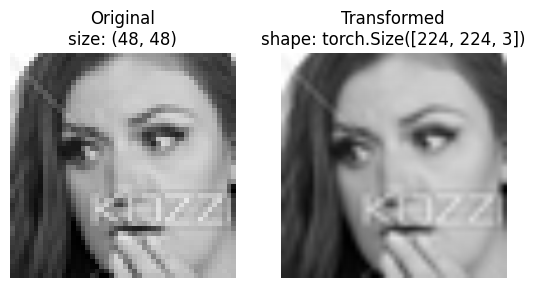

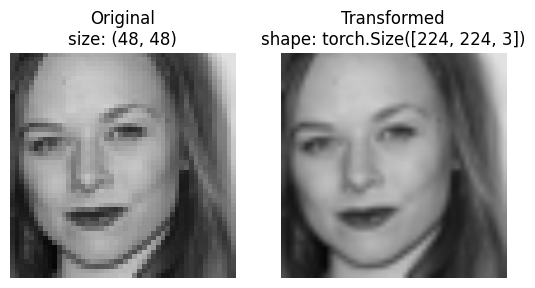

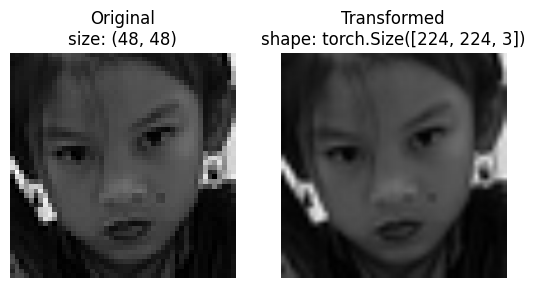

In [6]:
def plot_transformed_images(images_path: Path,
                            transform: transforms,
                            n: int=3,
                            seed = None) -> None:
    if seed:
        random.seed(seed)
    if n>10:
        print("n shouldn't be higher than 10 due to the size of displaye plot, changing n to 10")
        n = 10

    random_image_paths = random.sample(images_path, k = n)

    for image_path in random_image_paths:
        with Image.open(image_path).convert('RGB') as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nsize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nshape: {transformed_image.shape}")
            ax[1].axis(False)

plot_transformed_images(image_path_list, train_transform)

### 1.3 Prepare the data

In [7]:
train_dir = images_path / 'train'
val_dir = images_path / 'test'

train_data = datasets.ImageFolder(
    root = train_dir,
    transform = train_transform
)
val_data = datasets.ImageFolder(
    root = val_dir,
    transform = val_transform
)
val_data.classes

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

### 1.4 Set the dataloaders

In [8]:
batch_size = 8

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size= batch_size,
    shuffle = True,
    num_workers=4
)

val_dataloader = DataLoader(
    dataset = val_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4
)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

### 1.5 Prepare the model

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

본 학습에서는 efficientnet_b0을 사용한다.
[설명](https://velog.io/@seo78200/Birds400-EfficientNet)
- 모델의 성능 개선을 위해서 조정하는 부분은 크게 모델의 깊이(depth), 너비(width), 그리고 이미지의 해상도(resolution)이 있다. 이 모델에서는 이 세 가지의 요소를 동시에 조절하며 최대한 효율적인(efficient) 모델을 찾는다.

- ![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*cVE7XRpeJCmF-gwC.png)
- 기존 모델에서는 세 변수중 하나만을 고려한 성능개선 작업이 이루어졌는데, efficientnet에서는 세 요소를 동시에 고려한 _compound model scaling_ 을 제안했다. 그러기 위해 d, w, r 간의 관계를 찾아야 하는데
- ![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*Hi3H8-mW0DuwwqM6.png)
- 위에서 정의한 모델의 정확도를 최대한으로 높이는 d, w, r간의 관계를 찾고자 한다.
- ![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*Km9yxkmHZslaMmnt.png)
- 그렇게 고안된 최적의 균형(?) - phi 값은 사용자의 리소스에 맞게 임의로 넣어주면 된다. 주어진 제한조건을 만족하는 값들에 대해 grid search를 통한 최적의 값을 찾아내는 방법이다.

In [10]:
batch_size = 16

model = torchvision.models.efficientnet_b0().to(device)

summary(
    model = model,
    input_size = (batch_size, 3, 224, 224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 1000]           --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

In [11]:
output_shape = len(train_data.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280,
                    out_features = output_shape,
                    bias = True)).to(device)

summary(
    model = model,
    input_size = (batch_size, 3, 224, 224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 7]              --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

In [12]:
def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc
    
def val_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader, 
        loss_fn: torch.nn.Module,
        device: torch.device) -> Tuple[float, float, torch.Tensor]:
    with torch.inference_mode():

        model.eval()
        val_loss, val_acc = 0, 0
        y_preds = []

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim = 1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

        val_loss = val_loss / len(dataloader)
        val_acc = val_acc / len(dataloader)

        y_pred_tensor = torch.cat(y_preds)

        return val_loss, val_acc, y_pred_tensor


def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        val_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device) -> Tuple[Dict, torch.Tensor]:
    results = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc':[]}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_fn = loss_fn,
            device = device,
            optimizer=optimizer
        )

        val_loss, val_acc, y_preds = val_step(
            model = model,
            dataloader = val_dataloader,
            loss_fn=loss_fn,
            device = device
        )

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

    return results, y_preds


In [13]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

epochs = 10

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.01
)

start_time = timer()

model_results, preds = train(
    model = model,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    epochs=epochs
)
end_time = timer()
print(f"Total learning time: {(end_time - start_time):.3f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 1.770, Train acc: 0.273, Val loss: 1.978, Val acc: 0.367
Epoch: 2, Train Loss: 1.498, Train acc: 0.420, Val loss: 1.295, Val acc: 0.509
Epoch: 3, Train Loss: 1.325, Train acc: 0.499, Val loss: 1.210, Val acc: 0.541
Epoch: 4, Train Loss: 1.223, Train acc: 0.538, Val loss: 1.179, Val acc: 0.563
Epoch: 5, Train Loss: 1.149, Train acc: 0.571, Val loss: 1.087, Val acc: 0.589
Epoch: 6, Train Loss: 1.088, Train acc: 0.596, Val loss: 1.068, Val acc: 0.596
Epoch: 7, Train Loss: 1.034, Train acc: 0.615, Val loss: 1.073, Val acc: 0.611
Epoch: 8, Train Loss: 0.977, Train acc: 0.636, Val loss: 1.034, Val acc: 0.616
Epoch: 9, Train Loss: 0.937, Train acc: 0.652, Val loss: 1.075, Val acc: 0.616
Epoch: 10, Train Loss: 0.895, Train acc: 0.671, Val loss: 1.041, Val acc: 0.624
Total learning time: 1217.127


RuntimeError: Parent directory C:/Users/JonghyunShin/OneDrive - 고려대학교/KUCC/머신러닝 스터디(3-2) does not exist.

In [35]:
torch.save(model.state_dict(), f = './save.pt')

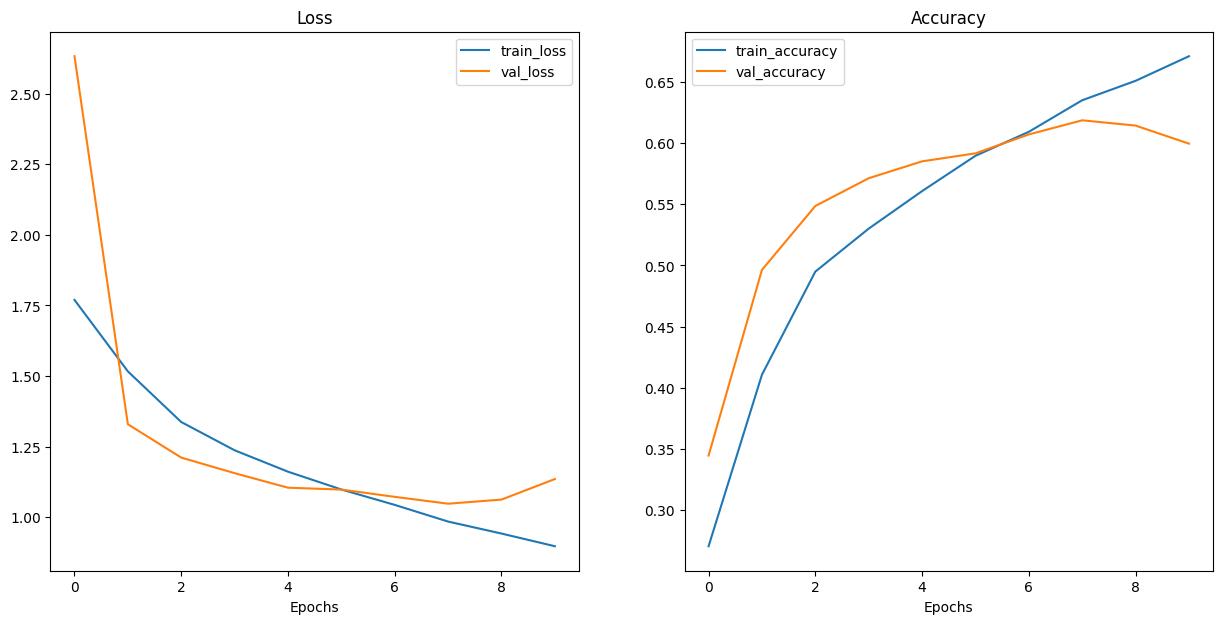

In [14]:
def plot_curves(results: Dict[str, List[float]]) -> None:
    train_loss = results['train_loss']
    val_loss = results['val_loss']


    train_accuracy = results['train_acc']
    val_accuracy = results['val_acc']
    epochs = range(len(results['train_loss']))
    plt.figure(figsize = (15, 7))
    plt.subplot(1, 2,1)
    plt.plot(epochs, train_loss, label = 'train_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label = 'train_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_curves(model_results)


In [16]:
def draw_confusion_matrix(data: datasets.ImageFolder,
                          preds: torch.Tensor) -> None:
    confmat = ConfusionMatrix(num_classes = len(data.classes))
    confmat_tensor = confmat(
        preds = preds,
        target = torch.ShortTensor(val_data.targets)
    )

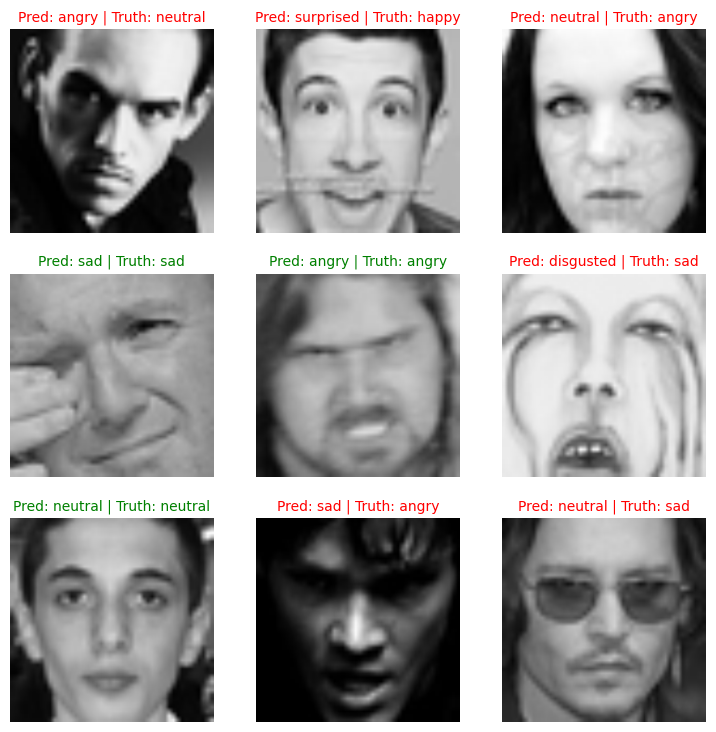

In [17]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.Tensor:
    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim = 0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

def show_predictions(model: torch.nn.Module,
                     device: torch.device,
                     val_data: datasets) -> None:
    val_samples = []
    val_labels = []

    for sample, label in random.sample(list(val_data), k = 9):
        val_samples.append(sample)
        val_labels.append(label)

    pred_probs = make_predictions(model = model,
                                  data = val_samples,
                                  device = device)
    pred_classes = pred_probs.argmax(dim = 1)
    plt.figure(figsize = (9, 9))
    nrows = 3
    ncols = 3

    for i, sample in enumerate(val_samples):
        plt.subplot(nrows, ncols, i+1)
        image = sample.squeeze().permute(1, 2, 0)
        plt.imshow(image)

        pred_label = val_data.classes[pred_classes[i]]
        truth_label = val_data.classes[val_labels[i]]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text, fontsize = 10, c = 'g')
        else:
            plt.title(title_text, fontsize = 10, c = 'r')
        plt.axis(False)

show_predictions(
    model = model,
    val_data = val_data,
    device = device
)

## 2. Train YOLOv5 to detect faces
### Get the data

In [12]:
zipfile_path = data_path / 'archive_humanface.zip'
images_path = data_path / 'faces_dataset/Human faces'
annotations_path = data_path / 'faces_dataset/Human faces/Data/Labels'

extract_data(zipfile_path, images_path)
images_path = images_path / 'Data/Images'

C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\faces_dataset\Human faces exists.
Data already extracted


C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\faces_dataset\Human faces\Data\Images


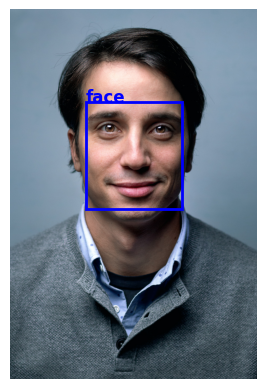

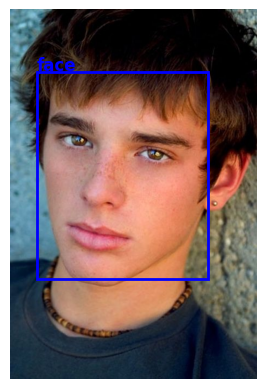

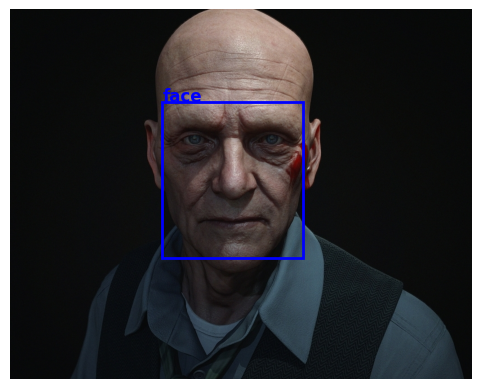

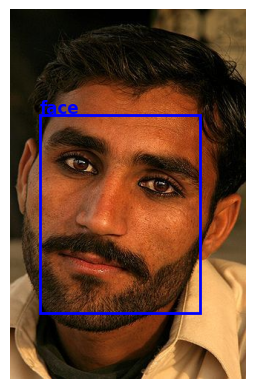

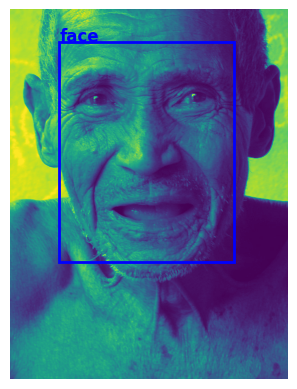

In [13]:
def print_random_images(photos: list, n: int = 5, seed = None) -> None:
    if n>10:
        n = 10
    if seed:
        random.seed(seed)
    for im in range(n):
        random_photo = random.choice(photos)
        random_photo_path = str(images_path)+'\\' + str(random_photo)

        with Image.open(random_photo_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)
            ax.axis(False)
            image_width, image_height = fd.size

        file = random_photo[:random_photo.index('.')]+'.txt'
        annotation_file = annotations_path / file

        with open(annotation_file) as f:
            label = f.read()
        labels = label.split(' ')
        labels[4] = labels[4][:-1]
        labels = list(map(float, labels))

        x1, y1, width, height = labels[1:]
        bbox_x = x1*image_width-image_width*width/2
        bbox_y = y1*image_height - image_height*height/2
        bbox_width = width*image_width
        bbox_heigth = height*image_height

        mpatch = mpatches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_heigth, linewidth = 1, edgecolor = 'b', facecolor = 'none', lw = 2)
        ax.add_patch(mpatch)
        rx, ry = mpatch.get_xy()
        ax.annotate('face', (rx, ry-2), color = 'blue', weight = 'bold', fontsize = 12, ha = 'left', va = 'baseline')

photos_list = [f for f in listdir(images_path) if isfile(join(images_path, f))]
print(images_path)
print_random_images(photos_list)

### 2.2 Use the splitfolders library to split data between training and validations sets

In [28]:
input_folder = Path('C:/Users/JonghyunShin/OneDrive - 고려대학교/KUCC/머신러닝 스터디(3-2)/Week3/faces_dataset/Human faces/Data')
output_folder = Path("C:/Users/JonghyunShin/OneDrive - 고려대학교/KUCC/머신러닝 스터디(3-2)/Week3/yolov5/data/Faces_detection")
splitfolders.ratio(
    input_folder,
    output = output_folder,
    seed = 42,
    ratio = (0.8, 0.2),
    group_prefix = None
)

Copying files: 1582 files [00:02, 700.74 files/s]


In [6]:
with open('C:/Users/JonghyunShin/OneDrive - 고려대학교/KUCC/머신러닝 스터디(3-2)/Week3/faces_dataset/Human faces/classes.txt') as f:
    classes = [classname.rstrip() for classname in f]

classes

['dog',
 'person',
 'cat',
 'tv',
 'car',
 'meatballs',
 'marinara sauce',
 'tomato soup',
 'chicken noodle soup',
 'french onion soup',
 'chicken breast',
 'ribs',
 'pulled pork',
 'hamburger',
 'cavity',
 'face']

In [7]:
def walk_through_dir(dir_path: Path) -> None:
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There ar {len(dirnames)} directories and {len(filenames)} files in {dirpath} folder" )

walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There ar 2 directories and 0 files in C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\faces_dataset\Human faces\Data folder
There ar 0 directories and 791 files in C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\faces_dataset\Human faces\Data\Images folder
There ar 0 directories and 791 files in C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\faces_dataset\Human faces\Data\Labels folder

There ar 2 directories and 0 files in C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\yolov5\data\Faces_detection folder
There ar 2 directories and 0 files in C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\yolov5\data\Faces_detection\train folder
There ar 0 directories and 632 files in C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\yolov5\data\Faces_detection\train\Images folder
There ar 0 directories and 632 files in C:\Users\JonghyunShin\OneDrive - 고려대학교\KUCC\머신러닝 스터디(3-2)\Week3\yolov5\data\Faces_detecti

- Yolo 모델을 이용하기 위한 yaml파일 생성 

In [34]:
yaml_file = 'C:/Users/JonghyunShin/OneDrive - 고려대학교/KUCC/머신러닝 스터디(3-2)/Week3/yolov5/data/faces.yaml'
yaml_data = dict(
    path = 'data/Faces_detection',
    train = 'train',
    val = 'val',
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style=False)

In [21]:
device_yolo = '0' if torch.cuda.is_available() else 'cpu'
device_yolo

'0'

- 얼굴 객체 탐지 학습은 YOLO를 이용한다.
- YOLO: object detection 에 사용되는 딥러닝 알고리즘
- step1: 입력이미지를 s by s 그리드 영역으로 나누고, 각 그리드 영역에서 물체가 있을 만한 영역에 해당하는 B개의 bounding Box를 예측한다. 다음으로 해당 박스의 신뢰도를 나타내는 confidence를 계산한다(해당 그리드에 물체가 있을 확률 * 예측한 박스와 truth box의 겹치는 영역의 비율). 다음으로, 각 그리드마다 클래스별 확률을 계산한다(P(class|Object))
- step2: 네트워크를 구성한다
- ![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlXBcK%2FbtqA3fhEAwX%2F61Au3YEcbhibDXd9tzF5x0%2Fimg.png)
- 앞쪽의 레이어는 단순한 convolution layer이고, 뒷단의 레이어가 객체탐지에 맞게 학습시키는 부분이다.
- 최종 출력(7*7*30)을 살펴보자
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FM4ls5%2FbtqA6oYXCSK%2FkOCavxkLNBYZ7K3gnNOznK%2Fimg.png)
- 7*7 은 그리드를 의미하며, 맨 첫 두개의 박스가 추측한 bounding box이다.(x, y, w, h, c)*2
나머지 20차원의 벡터는 해당 인덱스가 특정 클래스인 확률 값들을 의미한다. (해당 데이터셋의 클래스가 20개). (confidence * P(class|object)를 계산한 값)
- Loss Function 은 다음과 같다.
- ![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FrCcQj%2FbtqA4y2jGLZ%2FfAnyZVGJxmeNIQ1IRnpAkK%2Fimg.png)
- 1obj: i번째 인덱스의 j번째 바운딩박스가 낸 최종 prediction




In [37]:
start_time = timer()

!cd yolov5 && python train.py --workers 2 --img 640 --batch 16 --epochs 50 --data "data/faces.yaml" --weights yolov5s.pt --device {device_yolo} --cache
end_time = timer()

print(f'\nTraining time: {(end_time-start_time):.2f}')

^C

Training time: 7552.44


## 3. Validate the results

In [2]:
model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp4/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\JonghyunShin/.cache\torch\hub\master.zip
YOLOv5  2023-11-3 Python-3.11.2 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


In [1]:
import torch, torchvision
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp4/weights/best.pt', force_reload=True)

model_eff = torchvision.models.efficientnet_b0().to(device)
model_eff.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280,
                    out_features = 7,
                    bias = True)).to(device)
model_eff.load_state_dict(torch.load('./save.pt'))
model_eff.eval()

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\JonghyunShin/.cache\torch\hub\master.zip
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...
requirements:  Command 'pip install --no-cache "Pillow>=10.0.1" ' returned non-zero exit status 1.
YOLOv5  2023-11-5 Python-3.11.2 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [2]:
import cv2
import tensorflow as tf

video = "C:/Users/JonghyunShin/OneDrive - 고려대학교/KUCC/머신러닝 스터디(3-2)/Week3/sample_video.mp4"
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(video)

## Create transform for images detected by yolo
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

assert cap.isOpened()

## video loop
while(cap.isOpened()):
    ret, frame = cap.read()
    assert not isinstance(frame,type(None)), 'frame not found'
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)    
    results = model_yolo(frame)   
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    
    labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    width, height = frame.shape[1], frame.shape[0]
    
    for i in range(0, len(labels)):
        row = coordinates[i]
        if row[4] >= 0.4: ## if yolo detects face with prob > 0.4
            x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## get x, y of the bbox
            face_crop = frame[int(y1):int(y2), int(x1):int(x2)] ## crop the face

            transformed_image = (test_transform(face_crop)).unsqueeze_(0) ## create the transform of cropped imgae
            model_eff = model_eff.to(torch.device(device)) ## send model to device 
            transformed_image = transformed_image.to(torch.device(device)) ## send data to device
            
            pred_label = torch.max(model_eff(transformed_image), 1) ## get pred label
            # pred_class = val_data.classes[pred_label.indices.item()] ## get pred class
            pred_class = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'][pred_label.indices.item()]
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## create bbox rectangle
            cv2.putText(frame, f"{pred_class}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3) ## create bbox text
            
    cv2.imshow('YOLO', frame) ## show frame
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    ret, frame = cap.read()
    if not ret:
        break
        
cap.release()
cv2.destroyAllWindows()